# **Практическое задание**

**Домашнее задание к занятию (необязательное):**

Попробовать улучшить генерацию модели с занятия, если позволят ресурсы.

  

---



**Домашнее задание к курсу:**
1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети

2. Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?


## **Модель GAN**

*Ввиду необходимости больших ресурсов, рекомендации взяты из открытых источников.*

**Некоторые рекомендации по улучшению модели GAN:** 

1. Нормализовать входные данные в диапазоне [-1, 1] и использовать функцию 'tanh' на выходе генератора.
2. Перевернуть метки и функцию потерь при обучении генератора.
3. Подавать на вход генератору числа из случайного распределения Гаусса.
4. Для расчета нормы батча использовать как настоящие, так и сгенерированные  мини-батчи.
5. Использовать Leaky ReLU в генераторе и дискриминаторе.
6. Использовать слои Average pooling, ConvTranspose2D и шаг в них для понижения дискретизации.
7. Использовать сглаживание меток в дискриминаторе с небольшим случайным шумом.
8. Использовать размеченные данные при их наличии.
9. Добавлять шум во входные данные дискриминатора и постепенно его уменьшать.
10. Использовать Dropout 50% во время обучения и генерации.


Источник:

https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

## **Архитектура распознавания образов на новом датасете 'cats_vs_dogs'**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import BatchNormalization
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
# functions

# fix random state
def randomstate(seed=42):
  np.random.seed(seed)
  tf.random.set_seed(seed)


# resize and normalize images
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255
  # label = tf.cast(label, tf.int32)
  return image, label


# visualization image
def plot_image(i, predictions_array, true_label, img, labels_name):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels_name[predicted_label],
                                100*np.max(predictions_array),
                                labels_name[true_label]),
                                color=color)
  
# visualization image + predition

def plot_value_array(i, predictions_array, true_label, len_labels):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len_labels))
  plt.yticks([])
  thisplot = plt.bar(range(len_labels), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'tf_cats_vs_dogs_trained_model.h5'

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 50
BUFFER_SIZE = 500

In [ ]:
# download data
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train, test), meta_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [ ]:
# get meta info
num_examples = meta_info.splits['train'].num_examples
num_classes = meta_info.features['label'].num_classes
label_names = meta_info.features['label'].names

print('Total number examples:', num_examples)
print('Label names:', label_names)

Total number examples: 23262
Label names: ['cat', 'dog']


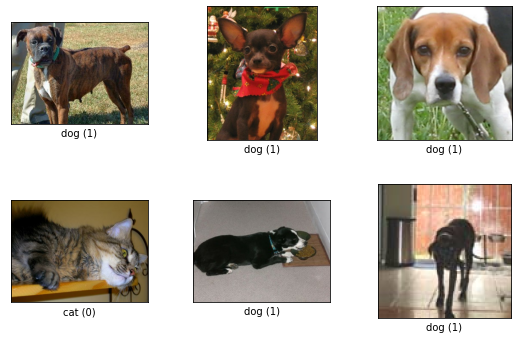

In [ ]:
# visualization
fig = tfds.show_examples(train.take(6), meta_info)

In [ ]:
# preprocess data
train = train.cache().shuffle(BUFFER_SIZE).map(format_image).batch(BATCH_SIZE).prefetch(BUFFER_SIZE)
test = test.map(format_image).batch(BATCH_SIZE).prefetch(BUFFER_SIZE)

In [ ]:
print(train.cardinality().numpy())
print(test.cardinality().numpy())

582
146


In [ ]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# neural network architecture
randomstate()
model = Sequential()


# convolution and max-pooling layers
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))


# fully connected layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
# compile the model
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(train,
         batch_size=BATCH_SIZE,
         epochs=5,
         validation_data=test
        )

Epoch 1/5
582/582 [==============================] - 35s 30ms/step - loss: 0.7554 - accuracy: 0.6507 - val_loss: 0.6049 - val_accuracy: 0.6533
Epoch 2/5
582/582 [==============================] - 11s 19ms/step - loss: 0.5160 - accuracy: 0.7474 - val_loss: 0.6519 - val_accuracy: 0.6341
Epoch 3/5
582/582 [==============================] - 11s 19ms/step - loss: 0.4378 - accuracy: 0.7961 - val_loss: 0.5026 - val_accuracy: 0.7584
Epoch 4/5
582/582 [==============================] - 11s 19ms/step - loss: 0.3703 - accuracy: 0.8378 - val_loss: 0.7407 - val_accuracy: 0.7167
Epoch 5/5
582/582 [==============================] - 11s 19ms/step - loss: 0.3148 - accuracy: 0.8650 - val_loss: 0.4859 - val_accuracy: 0.7861


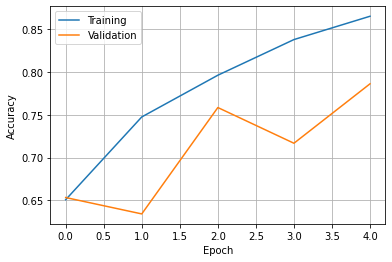

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [ ]:
# train score
scores = model.evaluate(train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

582/582 [==============================] - 3s 6ms/step - loss: 0.2157 - accuracy: 0.9205
Train loss: 0.2157309651374817
Train accuracy: 0.9204728603363037


In [ ]:
# test score
scores = model.evaluate(test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

146/146 [==============================] - 4s 29ms/step - loss: 0.4859 - accuracy: 0.7861
Test loss: 0.48594579100608826
Test accuracy: 0.7861135005950928


In [ ]:
X_test, y_test = next(iter(test.take(1)))
y_test =tfds.as_numpy( tf.cast(y_test, np.int64))

In [ ]:
# predict
predictions = model.predict(X_test)

In [ ]:
print(predictions[0],
      np.argmax(predictions[0]),
      y_test[0],
      sep='\n')

[0.59807926 0.40192077]
0
1


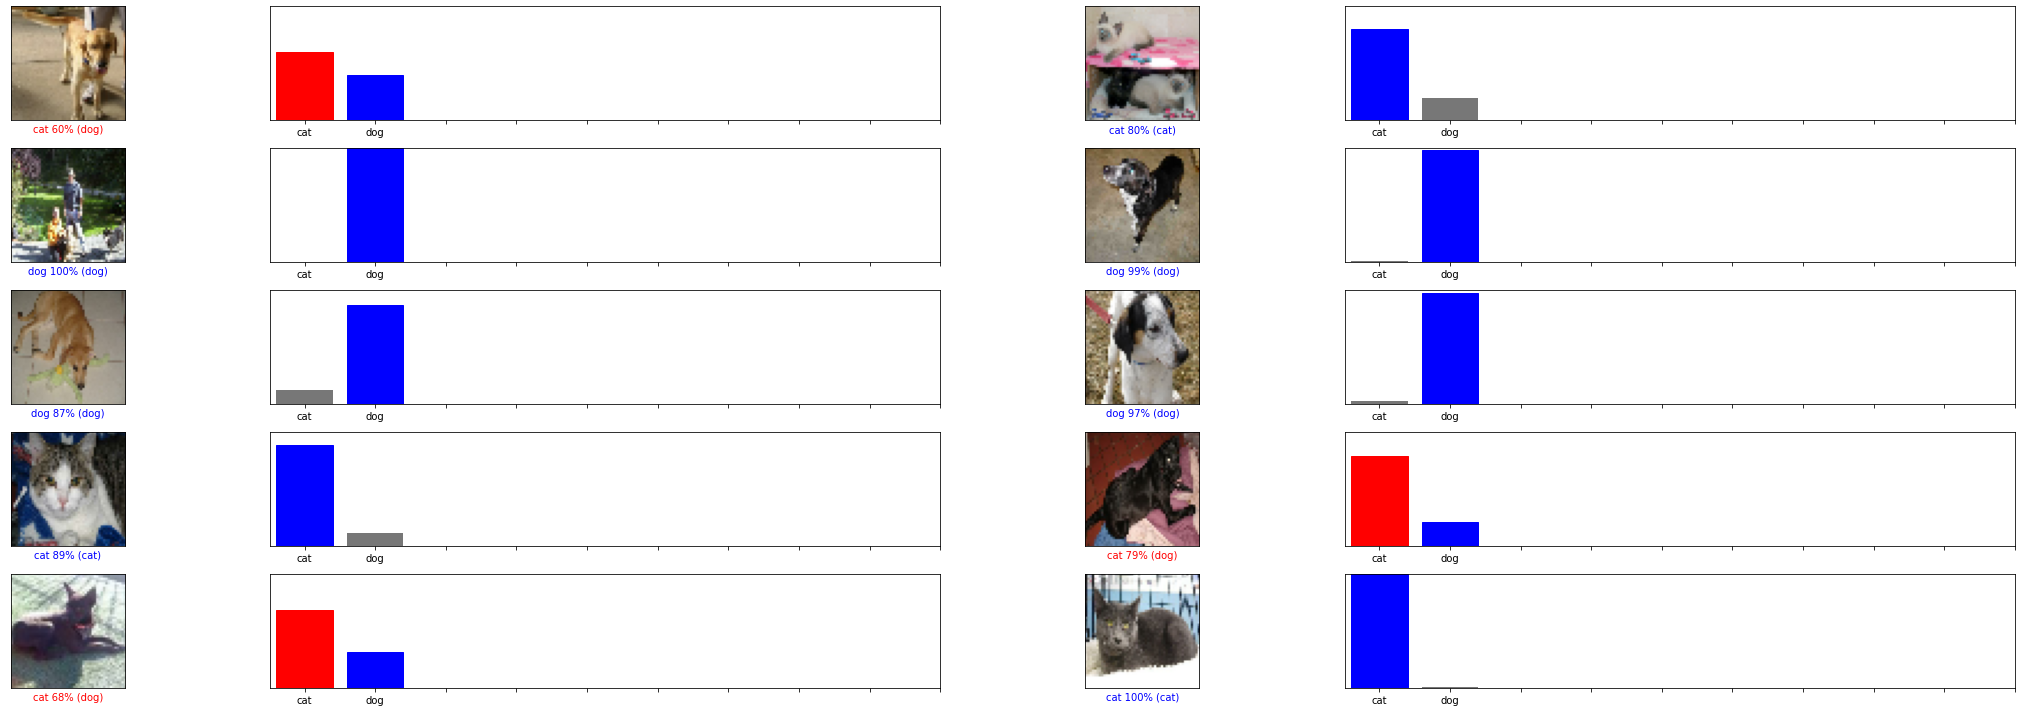

In [ ]:
# visualization predictions
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*8*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test, label_names)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)  
  plot_value_array(i, predictions[i], y_test, len(label_names))
  _ = plt.xticks(range(10), label_names, rotation=0) 

plt.tight_layout()

plt.show()

In [ ]:
# # сохранение модели и весов
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('сохранить обученную модель как %s ' % model_path)

сохранить обученную модель как /content/saved_models/tf_cats_vs_dogs_trained_model.h5 


**Наблюдения:**

1. Пришлось уменьшить размер изображения до 50х50, при размерах 256х256 и 128х128 не хватало ОЗУ и вылетало ядро.
2. C ImageDataGenerator качество модели сильно ухудшалось, также наблюдалось переобучение.
3. Scheduler на 5-ти эпохах результатов не дал. При большем числе эпох наблюдается сильное переобучение.
4. Dropout в 0.5 в последнем слое снизил переобучение.
6. Увеличение фильтров в слоях свертки ухудшило обучение.
7. Повышение метрики получилось благодаря следующим действиям: добавлению Dropout, BatchNormalization, стандартизации, увеличению нейронов в полносвязном слое, добавлению слоя свертки.

## **Краткий обзор архитектуры Deep belief networks (DBN)**

**Deep belief networks** — тип архитектуры, в которой сеть состоит из нескольких соединённых слоев так называемой Ограниченной машины Больцмана (**Restricted Boltzmann machine**, **RBM**). В свою очередь RBM является генеративной стохастической нейронной сетью, которая определяет распределение вероятности на входных образцах данных. В такой сети есть видимый слой и скрытые слои, при этом связи допустимы только между нейронами разного типа слоев.

<div>
<img src="https://www.researchgate.net/profile/Cong-Ou/publication/332671752/figure/fig1/AS:751866552000520@1556270363601/Architecture-of-a-Deep-Belief-Networks-DBNs-and-b-Restricted-Boltzmann-Machines.png" width="800"/>
</div>

(a) Архитектура Deep Belief Networks (DBNs) 

(b) Архитектура Restricted Boltzmann Machines (RBMs)




**Процесс обучения DBN:**

Берется слой нейронной сети, подается на вход RBM и происходит обучение, далее фиксируются полученные веса. Затем выход подается на вход  следующей RBM, она рассматривается как отдельная часть, происходит обучение и фиксирование весов. Так проходят по всей сети. В итоге все выходы RBM объединяются в одну большую сеть. После могут добавляться дополнительные слои других видов.

**Пример реализации сети:**

https://github.com/JosephGatto/Deep-Belief-Networks-Tensorflow/blob/master/Deep%20Belief%20Networks%20Tensorflow.ipynb


Таким образом, у DBN есть два этапа: предварительное обучение (то есть обучение без учителя) и обучение с дополнительными настройками/параметрами. Первый этап помогает сети лучше обобщать, второй - позволяет настроить  предварительно обученные веса под конкретную задачу (например, бинарная классификация, многоклассовая классификация и т. д.) с небольшим набором размеченных данных.

**Преимущества:**

1. Исключается случайная инициализация весов – сеть обучена восстанавливать или генерировать данные предыдущего слоя. На практике это приводит к тому, что такие нейронные сети довольно неплохо обучены. Их можно слегка дообучить дополнительными примерами, и качество сети будет хорошим.

2. Работа с неразмеченными данными, можно использовать датасеты без заготовленных классов.

**Недостатки:**

1. Данная архитектура относится к жадным алгоритмам, таким образом не всегда возможно нахождение глобального оптимального решения для задачи, а также нужны большие вычислительные мощности.


**Сферы применения DBN:**

 - генерация изображений
 - классификация изображений
 - распознавание видео
 - захват движения
 - обработка естественного языка (обработка речи).

<div>
<img src="https://www.researchgate.net/publication/343579398/figure/fig3/AS:932501505712128@1599337092044/Work-frame-of-deep-belief-network-DBN-convolutional-neural-network-CNN-lncRNA.png" width="1000"/>
</div>

Пример объединения DBN и CNN в новую сеть **Convolutional Deep Belief Networks (CDBN)** для работы с изображениями.

Источники:

https://proceedings.neurips.cc/paper/2006/file/5da713a690c067105aeb2fae32403405-Paper.pdf

https://tproger.ru/translations/neural-network-zoo-1/

https://habr.com/ru/company/oleg-bunin/blog/340184/

https://www.researchgate.net/publication/332671752_Integrating_Cellular_Automata_with_Unsupervised_Deep-Learning_Algorithms_A_Case_Study_of_Urban-Sprawl_Simulation_in_the_Jingjintang_Urban_Agglomeration_China

https://www.researchgate.net/publication/343579398_Identifying_Cancer-Related_lncRNAs_Based_on_a_Convolutional_Neural_Network

https://medium.com/swlh/what-are-rbms-deep-belief-networks-and-why-are-they-important-to-deep-learning-491c7de8937a

https://www.cs.toronto.edu/~hinton/absps/ruhijournal.pdf

https://ru.wikipedia.org/wiki/%D0%9E%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%87%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%B0_%D0%91%D0%BE%D0%BB%D1%8C%D1%86%D0%BC%D0%B0%D0%BD%D0%B0